# Assignment 2

**Deadline**:  01/10/2024, 17.00

**Names and student numbers:**
1. Paolo Cadei (14060876)
2. ...
3. ...

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:
1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.

## Instructions for completing and submitting the assignment
Please pay attention to the following instructions:
1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.
4. You are allowed to work on the assignment in groups of 2 or 3 students and to submit together. Before you submit, you and your team members have to register as an **Assignments group** on Canvas. Only a single member of each group has to submit the notebook. Please do **NOT** submit the same notebook multiple times!
5. Please write your names also inside this markdown cell, under **Names and student numbers**.

# IMPORTANT: RESTRICTION ON ALLOWED LIBRARIES!!!
You are **NOT** allowed to use any scikit-learn models and functions, except `Kfold` (possibly needed in part 2) and `datasets` (needed in part 2). Material from the computer classes, including the solutions, can be used and copied freely and without penalty.

## Part 0: importing the relevant libraries

**Exercise 1:** import all the libraries you are using in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import KFold

**Auxiliary functions:** you will need the functions in the cell below to run the notebook. Do not change these functions at any time!!!

In [2]:
def contour_plot_bivariate_Gaussian(subplot, mu = np.array([0., 0.]), Sigma = np.eye(2)):
    
    # Our 2-dimensional distribution will be over variables X and Y
    N = 40
    X = np.linspace(-2, 2, N)
    Y = np.linspace(-2, 2, N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    def multivariate_gaussian(pos, mu, Sigma):
        """Return the multivariate Gaussian distribution on array pos."""

        n = mu.shape[0]
        Sigma_det = np.linalg.det(Sigma)
        Sigma_inv = np.linalg.inv(Sigma)
        N = np.sqrt((2*np.pi)**n * Sigma_det)
        # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
        # way across all the input variables.
        fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

        return np.exp(-fac / 2) / N

    # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)
    
    subplot.contourf(X, Y, Z, cmap=cm.viridis) 

## Part 1: Bayesian learning
Recall the polynomial regression model with Gaussian noise. Given is a set of N datapoints $\mathcal{D}_N = \{ (x_n, y_n) \}_{n=1}^N,$ which are assumed to be modeled by a mean plus Gaussian noise:
$$
y = f(x, \vec{\beta}) + \epsilon, \qquad \epsilon \thicksim \mathcal{N}(0,\sigma^2),
$$
where $f(x, \vec{\beta}) =\vec{\beta} \cdot \vec{\phi}(x)$ with polynomial basis functions $\phi_i(x) = x^i$ for $i=0,1,2, \ldots, M.$

In the Bayesian learning approach for the model parameters $\vec{\beta},$ we define a prior
$$ \vec{\beta} \thicksim \mathcal{N} (\vec{0}, \sigma_0^2 I).$$
Combined with the Gaussian likelihood coming from the model assumptions, it is possible to derive the following posterior:
$$
\vec{\beta} |\mathcal{D}_N \thicksim \mathcal{N} \left( \vec{\mu}_N, {\bf S}_N  \right),
$$
where the posterior mean is given by
$$
\vec{\mu}_N = \frac{1}{\sigma^2} {\bf S}_N {\bf X}^T \vec{y},
$$
with
$$
{\bf X} = \left(
\begin{matrix}
\phi_0 (x_1) & \cdots & \phi_M (x_1) \\
\phi_0 (x_2) & \cdots & \phi_M (x_2) \\
\vdots & \vdots & \vdots \\
\phi_0 (x_N) & \cdots & \phi_M (x_N)
\end{matrix}
\right), \qquad \vec{y} = \left(
\begin{matrix}
y_1 \\
y_2 \\
\vdots \\
y_N
\end{matrix}
\right),
$$
and with a posterior variance-covariance matrix ${\bf S}_N$ speficied by
$$
\left({\bf S}_N\right)^{-1} = \frac{1}{\sigma_0^2}I + \frac{1}{\sigma^2} {\bf X}^T {\bf X}.
$$
In the following exercise, we will apply the Bayesian learning approach to the data that is imported and plotted in the cell below.

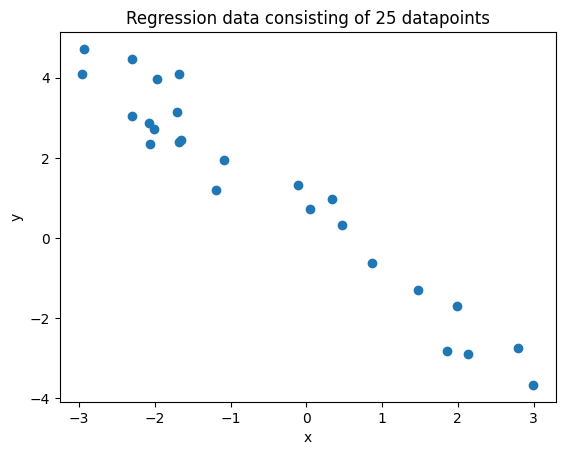

In [3]:
data = np.loadtxt("DSM_assignment2_data_Bayes.csv")
X = data[:,0]
Y = data[:,1]
N = len(X)

fig, ax = plt.subplots()

ax.scatter(X, Y)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Regression data consisting of {} datapoints".format(N));

**Exercise 2:** The formulas above describe the Bayesian learning approach for a dataset of a fixed size. In practice however, data often becomes available sequentially (e.g. real-time monitoring of patients). The goal of this exercise is to implement a sequential version of the Bayesian learning approach as the size of the dataset grows. The full dataset is stored in `X` (input feature) and `Y` (target variable). Suppose that initially the first $N' - 1 \, ( \leq N-1)$ datapoints are available. If we then observe the $N'$-th datapoint, we can update the posterior by multiplying the likelihood of the $N'$-th observation with the prior based on the first $N'-1$ observations. This prior corresponds to the posterior of the previous iteration.

We will do this for different sizes of the dataset $\mathcal{D}_{N'} = \{ (x_n, y_n) \}_{n=1}^{N'},$ where the size of the dataset can take values $N' = 1, 2, 3, 4, 8, 16$ and $25 (=N).$ A dataset of size $N'$ is created by simply taking the first $N'$ observations of the full dataset of size $N=25,$ which was imported in the cell above.

In this exercise, we restrict ourselves to linear regression models ($M=1$) and we will assume that $\sigma=\sigma_0 = 1.0$ are both known.

Given a dataset $\mathcal{D}_{N'} = \{ (x_n, y_n) \}_{n=1}^{N'}$ of size $N',$ you need to do the following:
* compute the parameters of the prior based on the first $N' - 1$ datapoints in the dataset.
* compute the parameters of the posterior based on the first $N'$ datapoints in the dataset.
* create 2-dimensional density plots of both the prior and posterior.
* plot 5 fits of the model, based on parameters randomly drawn from the posterior.

In the cell below, we helped you by giving you the template of the required plots. The priors and posteriors plotted in the template are all bivariate standard normal distributions. The 5 plotted fits through the data are simply linear functions with slope 1 and differing intercepts. It is your task to produce the correct priors, posteriors and fits.

In [4]:
def calculate_s(X, sigma_0, sigma_squared):

    '''
    X = X (N-1) prior values
    prior_sigma = variance of the prior distribution
    sigma_squared = variance of the Gaussian noise

    gram_matrix = X^TX
    '''

    gram_matrix = X.T @ X

    S_inverse = np.eye(2) / sigma_0 + gram_matrix / sigma_squared

    S = np.linalg.inv(S_inverse)

    return S

def posterior_mean(S, X, Y, sigma_squared):

    return (S @ X.T @ Y) / sigma_squared
 

def posterior(X, Y, sigma0, sigma_epsilon, N_prime):

    N = N_prime

    # addding constant of 1s to the X matrix (in the first column)
    X_subset = X[:N].reshape(-1, 1)
    constant = np.ones(X_subset.shape[0]).reshape(-1, 1)
    X_subset = np.append(constant, X_subset, axis = 1)

    # creating subset of y
    y_subset = Y[:N].reshape(-1, 1)

    # calculate posterior S for this iteration
    posterior_S = calculate_s(X_subset, sigma0, sigma_epsilon)

    # calculate posterior mean for this iteration
    posterior_m = posterior_mean(posterior_S, X_subset, y_subset, sigma_epsilon)

    output = posterior_m.flatten(), posterior_S

    return output

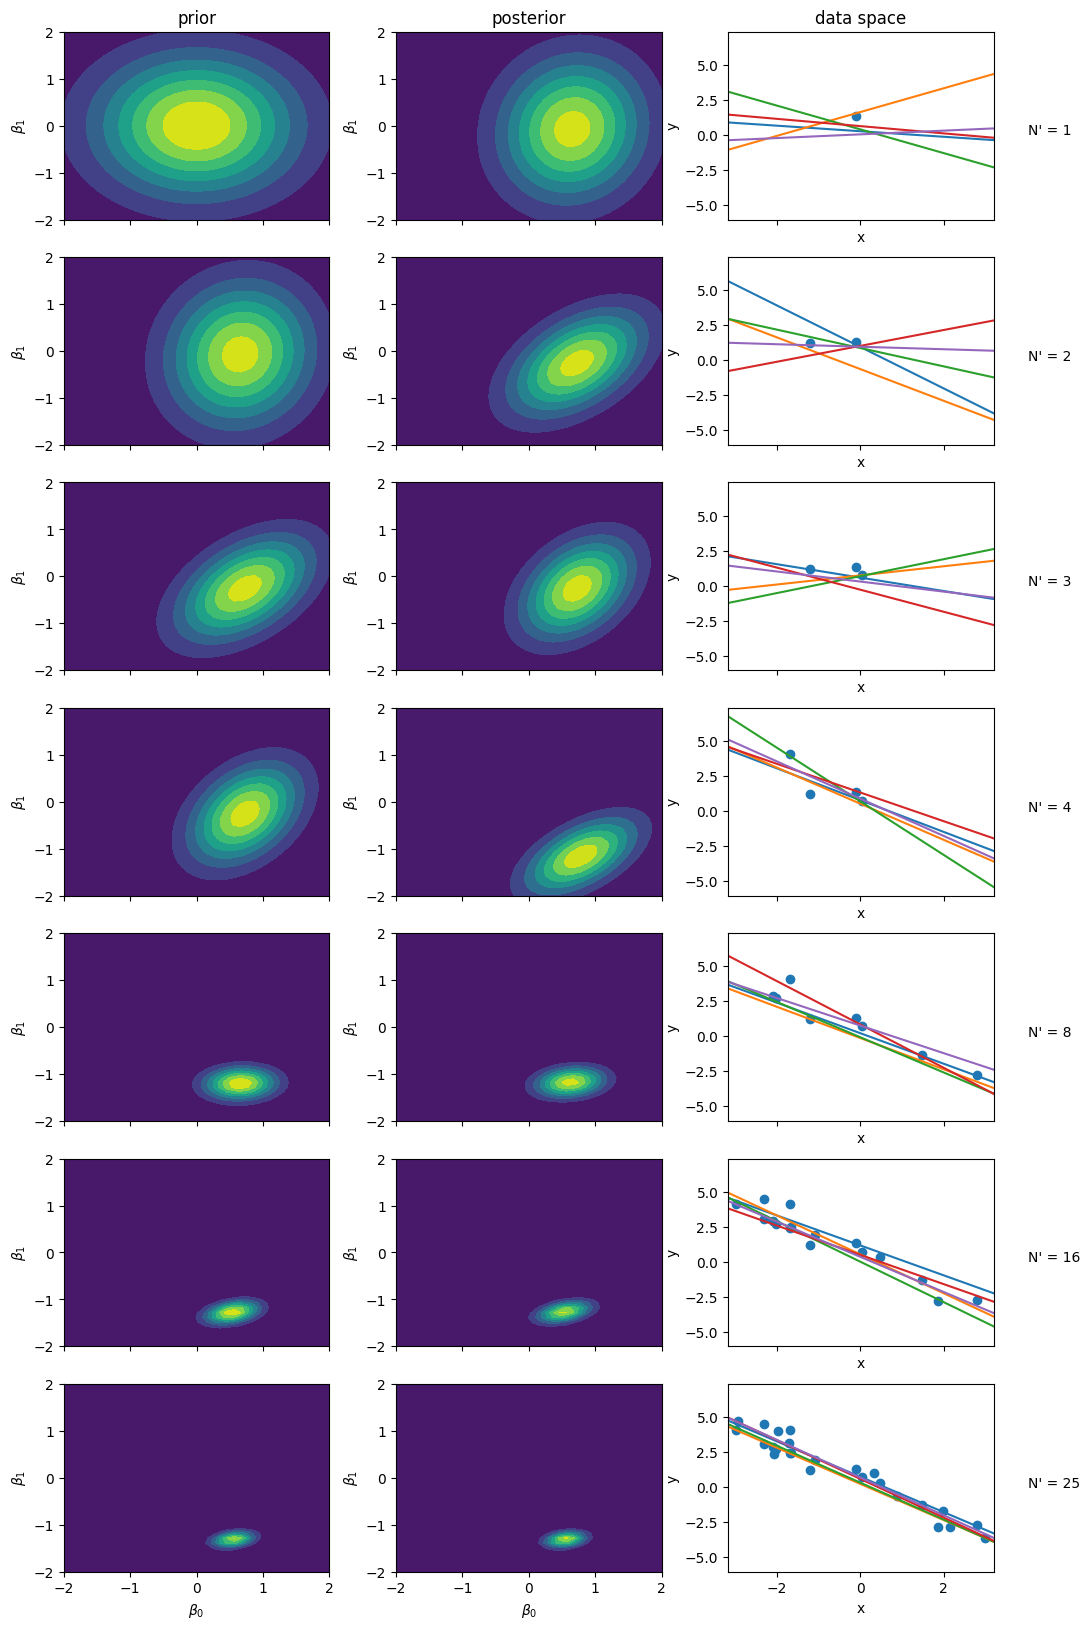

In [5]:
# The values of N_prime that we would like to plot

N = 25
N_primes = np.array([1, 2, 3, 4, 8, 16, N])

sigma = sigma0 = 1.0

# Creating the figure
fig, axes = plt.subplots(nrows=len(N_primes), ncols=3, sharex="col", sharey="col", figsize=(12,20))
fig.subplots_adjust(wspace=.25)
titles = ["prior", "posterior", "data space"]   # titles of the columns
x_range = np.linspace(min(X)-0.2, max(X)+0.2)   # x-coordinates for the linear functions is data space column
n_samples = 5     # number of linear functions plotted in data space column

for i, N_prime in enumerate(N_primes):
    
    # select the first N_prime data points
    Y_subset = Y[:N_prime]

    X_subset = X[:N_prime].reshape(-1, 1)
    constant = np.ones(X_subset.shape[0]).reshape(-1, 1)
    X_subset = np.append(constant, X_subset, axis = 1)

    if N_prime == 1:
        # compute the parameters of prior based on the first N_prime - 1 datapoints
        mu_prior, S_prior = np.zeros(2), sigma0**2 * np.eye(2)

    else:
        mu_prior, S_prior = posterior(X, Y, 1, 1, N_primes[i] -1)

    mu_post, S_post = posterior(X, Y, 1, 1, N_primes[i])


    for j in range(3):
        
        # plot the priors
        if j == 0:
            contour_plot_bivariate_Gaussian(axes[i,j], mu_prior, S_prior)
        # plot the posteriors
        if j == 1:
            contour_plot_bivariate_Gaussian(axes[i,j], mu_post, S_post)
        
        if j == 2:
            # plot the data
            axes[i, j].scatter(X_subset[:, 1], Y_subset)
            
            # plot a sample of fits based on parameters drawn from the posterior
            for k in range(n_samples):
                # Draw a sample from the posterior distribution of parameters
                sample = np.random.multivariate_normal(mu_post, S_post)
                
                # The sample contains the intercept (beta_0) and the slope (beta_1)
                beta_0, beta_1 = sample[0], sample[1]
                
                # Plot the line corresponding to the sampled parameters
                y_sample = beta_0 + beta_1 * x_range
                axes[i, j].plot(x_range, y_sample, label=f"Sample {k+1}")
        
        # layout and axes of the plots
        if i == 0:
            axes[i, j].set_title(titles[j])
        if j == 2:
            axes[i, j].text(4, 0, "N' = {}".format(N_prime))
        if i == len(N_primes)-1 and j<2:
            axes[i, j].set_xlabel(r"$\beta_0$")
        if j < 2:
            axes[i, j].set_ylabel(r"$\beta_1$")
            axes[i, j].set_xlim(left=-2, right=2)
            axes[i, j].set_ylim(bottom=-2, top=2)
        if j == 2:
            axes[i, j].set_xlabel("x")
            axes[i, j].set_ylabel("y")
            axes[i, j].set_xlim(left=min(X)-0.2, right=max(X)+0.2)

### Defining function to get the optimal parameter in exercises 2 and 3

In [6]:
def optimal_par(df, left=True):
    """
    Select the optimal parameter based on the One-Standard-Deviation Rule: 

    The function selects an optimal parameter from the input DataFrame, by first identifiing the lowest
    mean value and the corresponding standard deviation. 
    Then it considers only the parameters whose means fall within the range of one standard deviation 
    above or below the minimum mean. 
    To reduce model complexity, the optimal parameter is now chosen to be either the leftmost parameter in
    this range (if a low value of the hyperparameter indicates low model complexity), or the rightmost 
    parameter in this range (if a high value of the hyperparameter indicates lower model complexity)
    
    Parameters
    ----------
    input_dict : df
        A DataFrame containing [means, standard deviations]
    left : bool, optional
        If True (default), the function selects the leftmost parameter within the range. 
        If False, the function selects the rightmost one.

    Returns
    -------
    tuple
        A tuple where the first element is the key (the parameter) corresponding to the optimal parameter 
        and the second element is the value (mean, std) associated with that key.

    """
    
    # Extracting the means and standard deviations from the input dictionary
    means = df['accuracy']
    stds = df['std']

    # Finding the index of the parameter with the minimum mean
    opt_index = means.argmin()
    
    # Getting the standard deviation corresponding to the minimum mean
    opt_std = stds[opt_index]

    # Creating a boolean mask for means within one standard deviation of the minimum mean
    condition = (means > means.min() - opt_std) & (means < means.min() + opt_std)

    if left:
        # If 'left' is True, select the leftmost valid parameter
        final_opt_index = np.argmax(condition)
    else:
        # If 'left' is False, select the rightmost valid parameter
        reversed_mask = condition[::-1]  # Reverse the boolean mask
        last_true_index_reversed = np.argmax(reversed_mask)  # Find the first True value in the reversed mask
        
        # If any valid parameter exists, calculate its original index
        if np.any(condition):
            final_opt_index = len(condition) - last_true_index_reversed - 1
    
    # Returning the key and value corresponding to the optimal parameter
    return df['accuracy'][final_opt_index], df['std'][final_opt_index]


## Part 2: classification using LDA and logistic regression
In this part of the assignment, we will apply different classification methods to the `moons` data generating process of scikit-learn, which is imported and visualized in the cell below.

Hint: you may use/copy material of the computer classes (including the solutions) freely and without penalty.

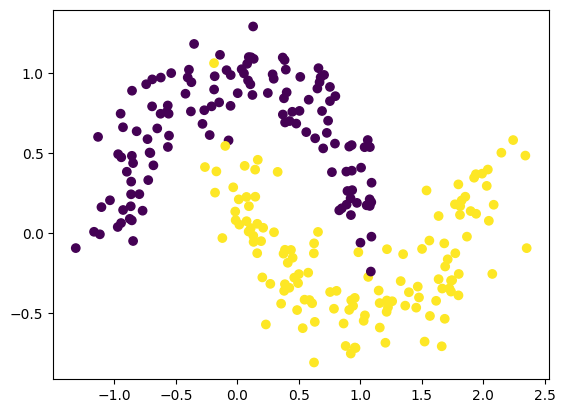

In [7]:
# DO NOT CHANGE THIS CELL!!! #
X_moons, y_moons = datasets.make_moons(n_samples = 256, noise = .15)
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons);

**Exercise 3:** use Linear Discriminant Analysis (LDA) to determine the prediction regions, based on the classification dataset given by `X_moons` and `y_moons`. Your solution should consist of two parts:
* implementation of the method (i.e., writing a training function that trains a model using this method and returns a predictor function).
* visualization of the prediction regions.

Note: your are **not** allowed to use any training methods/functions from existing packages or modules.

### Defining the LDA model

In [8]:
def estimate_pi(Y):

    # Y as numpy array

    probabilities = [len(Y[Y == k])/len(Y) for k in np.unique(Y)]

    return probabilities

def estimate_mus(X, Y):

    mus = np.zeros(shape=(len(np.unique(Y)), X.shape[1]))

    for i, k in enumerate(np.unique(Y)):

        mus[i,: ] = np.mean(X[Y == k], axis = 0)

    return mus

def estimate_sigma(X, Y, mus):

    diff = np.zeros(shape = X.shape)

    for i, k in enumerate(np.unique(Y)):
        diff[Y == k, :] = X[Y == k, :] - mus[i, :]

    sigma = (diff.T @ diff) / (X.shape[0] - len(np.unique(Y)))

    return sigma
    

def train_lda_classification(X, Y, K_classes = 2):

    '''
    x = variable we want to check
    X = X training
    Y = Y training
    '''
   
    pis = estimate_pi(Y)
    mus = estimate_mus(X, Y)
    s = estimate_sigma(X, Y, mus)

    def G(x_new):
    
        deltas = []

        for i, k in enumerate(np.unique(Y)):

            inv_s = np.linalg.inv(s)
            diff = x_new - mus[i, :]

            delta = - 1/2 * np.sum(diff @ inv_s * diff, axis = 1 ) + np.log(pis[k])
            deltas.append(delta)

        deltas = np.vstack(deltas).T

        return np.unique(Y)[np.argmax(deltas, axis = 1)]
    
    return G

### Defining Polynomial Features and Accuracy

In [9]:
def derived_features(X, M, bias=False):
    if bias:
        return np.concatenate(tuple([X**n for n in range(M+1)]), axis=1)
    if not bias:
        return np.concatenate(tuple([X**n for n in range(1, M+1)]), axis=1)

def accuracy(training_method, X, y, K_cv=10, runs=1):
    
    N = len(y)
    
    misclassifications = np.array([])
    for run in range(runs):
        
        cv_folds = KFold(n_splits=K_cv, shuffle=True) # Randomly creating new folds for each run
        
        for indices_train, indices_test in cv_folds.split(X):
            
            X_train = X[indices_train]
            y_train = y[indices_train]

            X_test = X[indices_test]
            y_test = y[indices_test]

            G_fitted = training_method(X_train, y_train) # Fitting model in training data
            y_fitted_test = G_fitted(X_test) # Using fitted model to predict on test data

            no_misclassifications = np.sum(y_fitted_test != y_test) # Counting number of prediction errors test data
            misclassifications = np.append(misclassifications, no_misclassifications)
    
    accuracy = 1 - np.sum(misclassifications)/(N*runs)
    std_error = np.std(misclassifications, ddof=1)*np.sqrt(K_cv/runs)/N
    
    return accuracy, std_error

def plot_classification(X, y, K, dir1, dir2, G=None, title=None, labels=['a', 'b'], poly = 1):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    if title:
        ax.set_title(title)
    colors = ['purple', 'red', 'red']
    
    if np.isscalar(dir1):
        dir_temp = np.zeros(X.shape[1])
        dir_temp[dir1] = 1.
        dir1 = dir_temp    
    if np.isscalar(dir2):
        dir_temp = np.zeros(X.shape[1])
        dir_temp[dir2] = 1.
        dir2 = dir_temp
    dir1 = dir1/np.linalg.norm(dir1)
    dir2 = dir2/np.linalg.norm(dir2)
    
    # Plotting the observations in the data set
    for k in range(K):
        boolean_index = y==k
        ax.scatter(np.dot(X[boolean_index], dir1), np.dot(X[boolean_index], dir2), c=colors[k], label=labels[k])    
    
    # Creating classification regions
    if G:
        points = 200
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        x_range = np.linspace(xmin, xmax, points)
        y_range = np.linspace(ymin, ymax, points)

        xx, yy = np.meshgrid(x_range, y_range)


        x_calculated = np.outer(xx, dir1) + np.outer(yy, dir2)

        x_calculated = derived_features(x_calculated, poly)

        G_grid = G(x_calculated).reshape(points, points)
    
        ax.contourf(x_range, y_range, G_grid, 2, alpha=.2, colors=colors)
    
    ax.set_xlabel("Direction 1: {}".format(dir1))
    ax.set_ylabel("Direction 2: {}".format(dir2))

    ax.legend();

## Modelling the date based on the LDA model without polynomial features

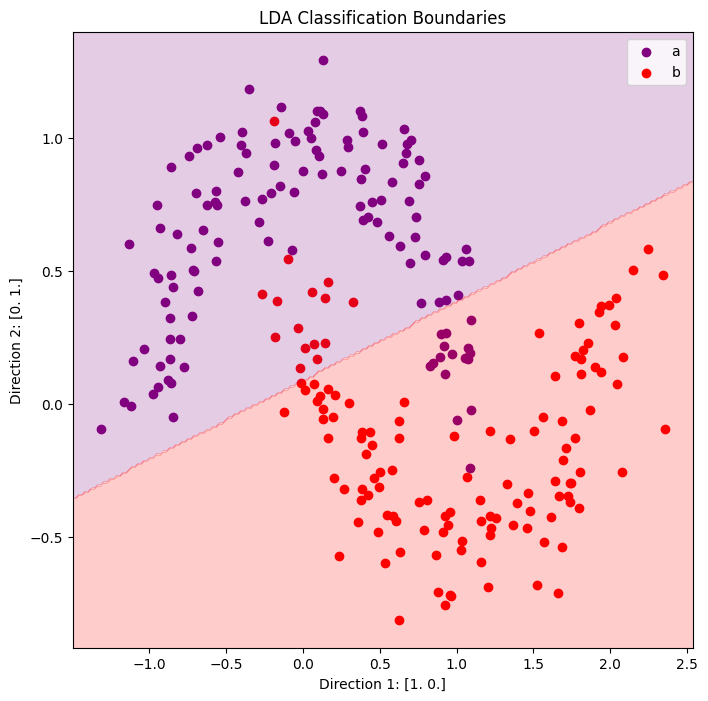

In [10]:
plot_classification(X_moons, y_moons, 2, 0, 1, train_lda_classification(X_moons, y_moons), title = 'LDA Classification Boundaries')

**Exercise 4:** in the above exercise, we see that LDA performs poorly on this dataset. However, with some small adjustments one can get a much better prediction accuracy. Repeat all the three steps of the previous exercise, but now for LDA with an increased feature space. Choose your derived features smartly.

Note: your are **not** allowed to use any training methods/functions from existing packages or modules.

### Creating a DataFrame containg the accuracy and the std for various polynomial degrees

In [11]:
M_range = 19

data = []

for M in range(2, M_range):

    X_derived = derived_features(X_moons, M)

    lda_model = accuracy(train_lda_classification, X_derived, y_moons)

    data.append({
                'degree': M,
                'accuracy': lda_model[0],
                'std' : lda_model[1]
                })
        
df = pd.DataFrame(data)


### Plotting the DataFrame to choose the polynomial degree

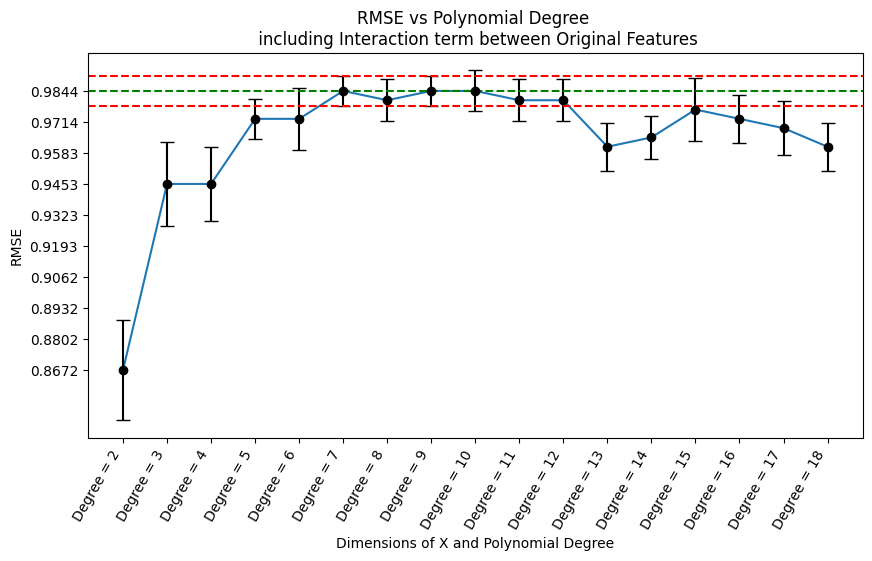

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(df['degree'], df['accuracy'])
plt.errorbar(df['degree'], df['accuracy'], yerr=df['std'], capsize=5, fmt='o', color='black') # Add error bars to the plot to show the standard error for each K
plt.axhline(y=max(df['accuracy']), linestyle='--', c='green')
plt.xticks(
    ticks=df['degree'],  # The positions of the ticks should correspond to the degree values
    labels=[f'Degree = {degree}' for degree in df['degree']],  # Custom labels
    rotation=60,  # Rotate for better readability (optional)
    ha='right'  # Align labels to the right (optional)
)
plt.yticks(np.linspace(min(df['accuracy']), max(df['accuracy']), 10))

min_mean = max(df['accuracy'])
min_std = df['std'][np.argmax(df['accuracy'])]

# Adding horizontal dashed lines to represent the RMSE range within one standard deviation of the minimum
plt.axhline(y=min_mean - min_std, linestyle='--', c='red')
plt.axhline(y=min_mean + min_std, linestyle='--', c='red')

plt.title('RMSE vs Polynomial Degree \n including Interaction term between Original Features')
plt.xlabel('Dimensions of X and Polynomial Degree')
plt.ylabel('RMSE');
#plt.yticks(np.linspace(min(means), max(means), 8))

### Using the LDA classifying algorithm on the chosen ('optimal') number of features

In [13]:
optimal_par(df, left=True)

(0.8671875, 0.021156350012072816)

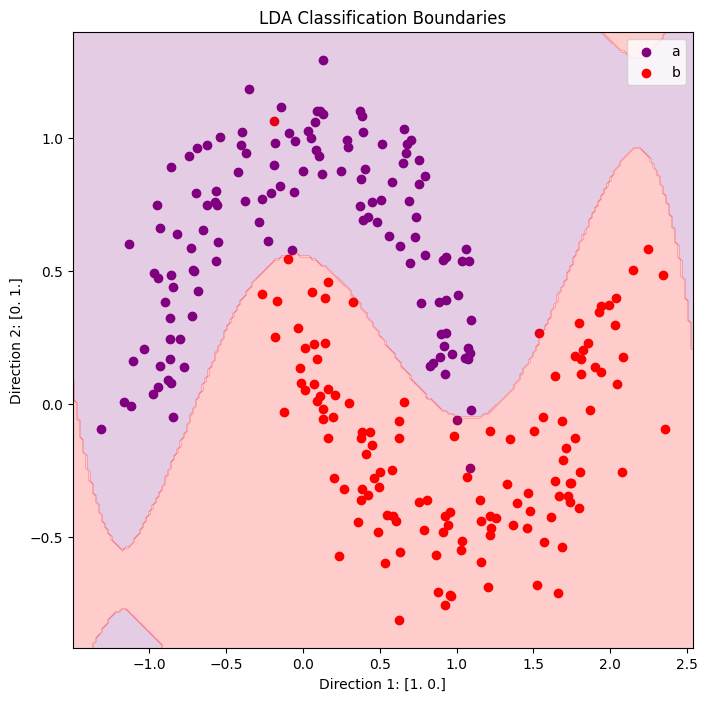

In [14]:
degree_poly = 5

X_derived = derived_features(X_moons, degree_poly)

plot_classification(
    X_moons,
    y_moons,
    2,
    0,
    1,
    train_lda_classification(X_derived, y_moons),
    title = 'LDA Classification Boundaries',
    poly = degree_poly)

**Exercise 5:** repeat the previous two exercises, but now for logistic regression instead of LDA.

Note: your are **not** allowed to use any training methods/functions from existing packages or modules.

### Defining Logistic Regression model

In [15]:
def preprocess(X, Y, batch_size=None):
    """
    Data preprocessing. Flatten the features of the 2-dimensional image data and
    regroups the data in batches.
    """    
    N = len(X)
    X = X.reshape(N, -1)
    
    X = np.hstack((np.ones(N).reshape(-1,1), X))
    
    if batch_size is not None:
        n_batches = N // batch_size
        X = X[:n_batches*batch_size].reshape(n_batches, batch_size, -1)
        Y = Y[:n_batches*batch_size].reshape(n_batches, batch_size)
        
    return X, Y, N

def compute_p(X, beta, preprocessed=True):
    """
    Computes the modeled probability that of an image being of class 1.
    """
    if not preprocessed:
        N = len(X)
        X = X.reshape(N, -1)
        X = np.hstack((np.ones(N).reshape(-1,1), X))
    
    exp = np.exp(X @ beta)
    
    return exp / (1 + exp)

def compute_gradient(X, Y, beta):
    """
    Computes the gradient of the loss function (=minus log-likelihood).
    """
    p = compute_p(X, beta)
    
    return - (Y - p) @ X

def train_logistic_regression(X, Y, learning_rate=0.01, batch_size=20, epochs = 100, reporting=False):
    """
    Trains a logistic regression model using stochastic gradient descent. 
    """
    # get X in correct shape of batches, including intercept column
    X, Y, N = preprocess(X, Y, batch_size=batch_size)
    
    # initialize parameters
    n_features = X.shape[2] - 1
    beta = np.random.normal(loc=0.0, scale=1.0, size=(n_features+1,)) / np.max(X)
   
    i = 0
    while i < epochs:
        
        for j, X_batch in enumerate(X):
            
            Y_batch = Y[j]
            
            beta_old = beta
            gradient = compute_gradient(X_batch, Y_batch, beta_old)
            beta = beta_old - learning_rate * gradient
            
            if reporting:
                if j == 0: print("Epoch {}".format(i))
                if j % 5 == 0:
                    Y_predicted, _ = predict(X, beta, preprocessed=True)
                    compute_accuracy(Y_predicted, Y)
        
        i += 1  

    def G(X, beta = beta, preprocessed = False):

        y_predicted, p  = predict(X, beta, preprocessed)

        return y_predicted
    
    return G

def predict(X, beta, preprocessed=False):
    """
    Binary classification based on logistic regression model.
    """
    p = compute_p(X, beta, preprocessed=preprocessed)
    Y_ = np.zeros(p.shape, dtype=int)
    Y_[p > 0.5] = 1
    
    return Y_, p

def compute_accuracy(Y_predicted, Y):
    """
    Computes prediction accuracy.
    """
    
    mistakes = np.sum(np.abs(Y_predicted - Y))
    accuracy = 1 - mistakes / np.size(Y)
    
    return accuracy

### Modelling the data based on Logistic Regression model without polynomial features

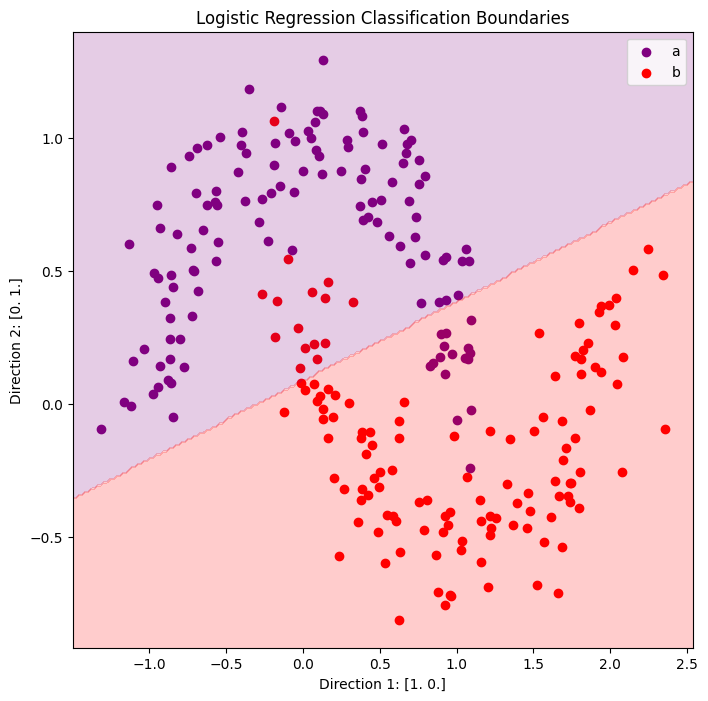

In [16]:
plot_classification(
    X_moons,
    y_moons, 
    2, 
    0, 
    1, 
    train_lda_classification(X_moons, y_moons), 
    title = 'Logistic Regression Classification Boundaries'
    )

### Creating a DataFrame containing the accuracy and std for various polynomial degrees

In [17]:
M_range = 15

data = []

for M in range(1, M_range):

    X_derived = derived_features(X_moons, M)

    accuracies = accuracy(train_logistic_regression, X_derived, y_moons)

    data.append({
                'degree': M,
                'accuracy': accuracies[0],
                'std': accuracies[1]
                })
        
df = pd.DataFrame(data)

/var/folders/n9/6pwt6r5x7cl54yr_vrdyfr_w0000gn/T/ipykernel_25210/4289921044.py:27: RuntimeWarning: overflow encountered in exp
  exp = np.exp(X @ beta)
/var/folders/n9/6pwt6r5x7cl54yr_vrdyfr_w0000gn/T/ipykernel_25210/4289921044.py:29: RuntimeWarning: invalid value encountered in divide
  return exp / (1 + exp)


### Plotting the DataFrame to choose the polynomial degree

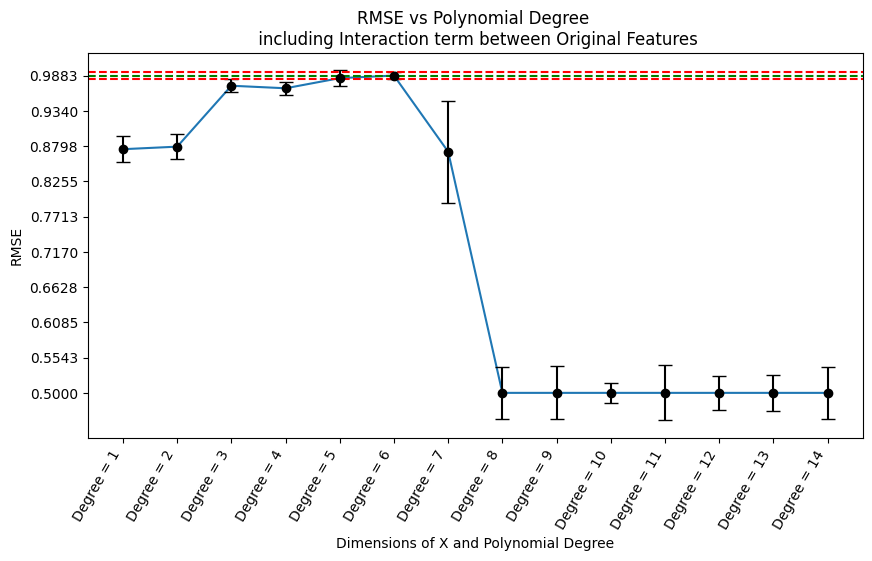

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(df['degree'], df['accuracy'])
plt.errorbar(df['degree'], df['accuracy'], yerr=df['std'], capsize=5, fmt='o', color='black') # Add error bars to the plot to show the standard error for each K
plt.axhline(y=max(df['accuracy']), linestyle='--', c='green')
plt.xticks(
    ticks=df['degree'],  # The positions of the ticks should correspond to the degree values
    labels=[f'Degree = {degree}' for degree in df['degree']],  # Custom labels
    rotation=60,  # Rotate for better readability (optional)
    ha='right'  # Align labels to the right (optional)
)
plt.yticks(np.linspace(min(df['accuracy']), max(df['accuracy']), 10))

min_mean = max(df['accuracy'])
min_std = df['std'][np.argmax(df['accuracy'])]

# Adding horizontal dashed lines to represent the RMSE range within one standard deviation of the minimum
plt.axhline(y=min_mean - min_std, linestyle='--', c='red')
plt.axhline(y=min_mean + min_std, linestyle='--', c='red')

plt.title('RMSE vs Polynomial Degree \n including Interaction term between Original Features')
plt.xlabel('Dimensions of X and Polynomial Degree')
plt.ylabel('RMSE');
#plt.yticks(np.linspace(min(means), max(means), 8))

### Using the Logistic Regression classyfing algorithm on the chosen ('optimal') number of features

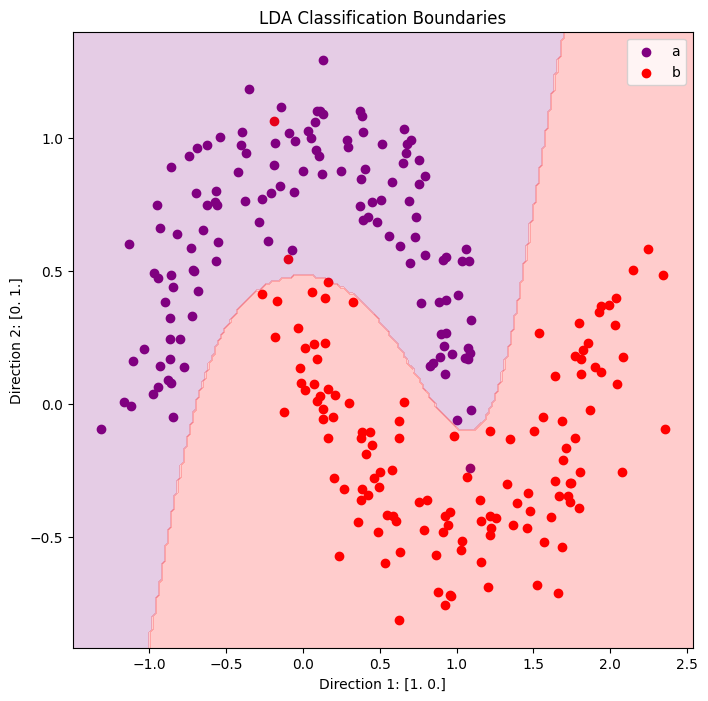

In [19]:
degree_poly = 5

X_derived = derived_features(X_moons, degree_poly)

plot_classification(
    X_moons,
    y_moons, 
    2, 
    0, 
    1, 
    train_logistic_regression(X_derived, y_moons, learning_rate=0.01, batch_size=20, epochs = 100, reporting=False ), 
    title = 'LDA Classification Boundaries', 
    poly = degree_poly
    )